# Text Classification

Harrison Kinsley has a Youtube channel by the name sentdex and he makes videos about python spanning across ML, AI, basic python, openCV, basic game programming etc. Gauge the popularity of his videos based on Machine Learning from this ML playlist:  https://www.youtube.com/playlist?list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v based on the Like to Dislike Ratio of the videos contained in this playlist

In [1]:
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import seaborn as sns
import nltk
%matplotlib inline

In [2]:
URL = "https://www.youtube.com/playlist?list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v"
r = requests.get(URL)
print(len(r.text))

340486


In [3]:
s = BeautifulSoup(r.text)
print(s.title.string)

Machine Learning with Python - YouTube


Scrape the parent page of playlists. Since every youtube link has a **watch** substring contained in it and also **index** substring to avoid duplication. Use this information and extract all those links from this parent page.

In [4]:
parent = "https://youtube.com"
all_video_links = []
title = []
for link in s.find_all('a'):
    #if "Practical Machine Learning " in link.text:
    child = link.get('href')
    l = link.text.strip()
    try:
        if ("watch" in child) and ("index" in child):
            all_video_links.append(parent + child)
            title.append(l)
    except:
        pass

In [5]:
while True:
    if "" in title:
        title.remove("")
    elif "Play all" in title:
        title.remove("Play all")
        title.remove("► Play all")
    else:
        break
len(title)

72

In [6]:
all_video_links = list(set(all_video_links))
for i in all_video_links:
    x = re.findall(r'.*index=(\d\d?).*', i)
    
all_video_links = sorted(all_video_links, key = lambda x: int(re.findall(r'.*index=(\d\d?).*', x)[0]) if len(re.findall(r'.*index=(\d\d?).*', x))>0 else 0)

Scrape individual links obtained in the list all_video_links above and extract likes and dislikes from those pages. From the source code it can be seen that the stats we need i.e. likes and dislikes are contained in the <button>button</button> tag and in it, the attribute <button>aria-label</button> contains that text. Hence extract this information from these tags respectively using regular expressions and bs4 & string fucntions.

<img src = "button_aria_label.png" w = 800 h = 200> 

In [7]:
summary = []
for j in range(0,len(all_video_links)):
    dislikes = 0
    likes = 0
    ri = requests.get(all_video_links[j])
    si = BeautifulSoup(ri.text)
    for i in si.find_all('button'):
        m = i.get('aria-label')
        try:
            if (isinstance(m, str)):
                if ('dislike' in m):
                    dislikes = re.findall(r'\d*,?\d+?', m)
                elif ('like' in m):
                    likes = re.findall(r'\d*,?\d+?', m)
        except:
            pass
    summary.append([all_video_links[j], title[j], likes, dislikes])

In [8]:
summary[:2]

[['https://youtube.com/watch?v=OGxgnH8y2NM&list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v&index=2&t=0s',
  'Practical Machine Learning Tutorial with Python Intro p.1',
  ['14,6', '82'],
  ['199']],
 ['https://youtube.com/watch?v=JcI5Vnw0b2c&list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v&index=3&t=0s',
  'Regression Intro - Practical Machine Learning Tutorial with Python p.2',
  ['6,3', '47'],
  ['137']]]

Create a dataframe from the list of summary above and get the stats of "Like" and "Dislike" in integer formats by using regular expressions. 

In [9]:
sum1 = pd.DataFrame(summary, columns = ['Link', 'Title', 'Likes', 'Dislikes'])

In [10]:
sum1.Likes = sum1.Likes.apply(lambda x: ''.join(x))
sum1.Dislikes = sum1.Dislikes.apply(lambda x: ''.join(x))

In [11]:
sum1.Likes = sum1.Likes.apply(lambda x: int(re.sub(',', '', x)))
sum1.Dislikes = sum1.Dislikes.apply(lambda x:int(re.sub(',', '', x)))

In [12]:
sum1['LDRatio'] = sum1.Likes/sum1.Dislikes

In [13]:
sum1.describe()

,Likes,Dislikes,LDRatio
count,72.000000,72.000000,72.000000
mean,979.027778,24.277778,46.384521
std,1896.700122,33.799001,21.117856
min,154.000000,3.000000,10.139535
25%,338.750000,7.000000,31.307692
50%,505.500000,12.000000,45.872727
75%,754.750000,23.500000,59.625000
max,14682.000000,199.000000,105.000000


In [14]:
q2 = sum1.describe().iloc[5,2]
q2

45.872727272727275

Let's consider those videos which have a Like to Dislike ratio of less than the first quartile value to be bad videos or not upto the mark videos. Let us assign them a value of 0 and let us assign those ones which have LDRatio of more than the median to be 1. 

In [15]:
x = []
for i in sum1.LDRatio:
    if i > q2:
        x.append(1)
    else:
        x.append(0)
sum1['Target'] = x

In [16]:
sum1.head()

,Link,Title,Likes,Dislikes,LDRatio,Target
0,https://youtube.com/watch?v=OGxgnH8y2NM&list=P...,Practical Machine Learning Tutorial with Pytho...,14682,199,73.778894,1
1,https://youtube.com/watch?v=JcI5Vnw0b2c&list=P...,Regression Intro - Practical Machine Learning ...,6347,137,46.328467,1
2,https://youtube.com/watch?v=lN5jesocJjk&list=P...,Regression Features and Labels - Practical Mac...,2900,116,25.000000,0
3,https://youtube.com/watch?v=r4mwkS2T9aI&list=P...,Regression Training and Testing - Practical Ma...,2196,78,28.153846,0
4,https://youtube.com/watch?v=QLVMqwpOLPk&list=P...,Regression forecasting and predicting - Practi...,1419,86,16.500000,0


# Bag of Words

In [17]:
from nltk.tokenize import word_tokenize
text = list(sum1.Title.str.lower())
docs = []
for i in text:
    docs.append(word_tokenize(i))

In [18]:
print(docs[:5])

[['practical', 'machine', 'learning', 'tutorial', 'with', 'python', 'intro', 'p.1'], ['regression', 'intro', '-', 'practical', 'machine', 'learning', 'tutorial', 'with', 'python', 'p.2'], ['regression', 'features', 'and', 'labels', '-', 'practical', 'machine', 'learning', 'tutorial', 'with', 'python', 'p.3'], ['regression', 'training', 'and', 'testing', '-', 'practical', 'machine', 'learning', 'tutorial', 'with', 'python', 'p.4'], ['regression', 'forecasting', 'and', 'predicting', '-', 'practical', 'machine', 'learning', 'tutorial', 'with', 'python', 'p.5']]


# Stemming

In [19]:
from nltk.stem import PorterStemmer

PS = PorterStemmer()
stemmed_doc = []
for doc in docs:
    d = []
    for i in doc:
        d.append(PS.stem(i))
    stemmed_doc.append(d)
print(stemmed_doc[:5])

[['practic', 'machin', 'learn', 'tutori', 'with', 'python', 'intro', 'p.1'], ['regress', 'intro', '-', 'practic', 'machin', 'learn', 'tutori', 'with', 'python', 'p.2'], ['regress', 'featur', 'and', 'label', '-', 'practic', 'machin', 'learn', 'tutori', 'with', 'python', 'p.3'], ['regress', 'train', 'and', 'test', '-', 'practic', 'machin', 'learn', 'tutori', 'with', 'python', 'p.4'], ['regress', 'forecast', 'and', 'predict', '-', 'practic', 'machin', 'learn', 'tutori', 'with', 'python', 'p.5']]


# Stopword Figuring and removal

In [20]:
from nltk.corpus import stopwords
SW = set(stopwords.words("english"))

In [21]:
sentences = []
for i in stemmed_doc:
    sentences.append(" ".join(i))
all_text = ""
for j in sentences:
    all_text = all_text + j + " "
all_text = re.sub(r'[\.\(\-\)/\d\']', '', all_text)

In [22]:
from nltk.probability import FreqDist
fdist=FreqDist(word_tokenize(all_text.strip()))

In [23]:
fdist.most_common(2)

[('with', 63), ('p', 58)]

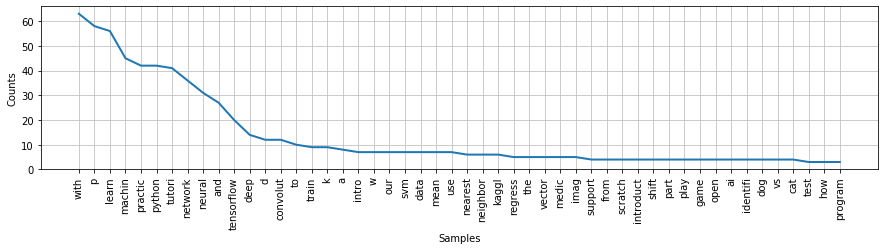

In [24]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 15,3
fdist.plot(50)
plt.show()

We can see that the words python, practic, machin, learn, p and with occur more than 40 times. Therefore, let's include these in our list of stop words as well.

In [25]:
SW = SW.union(set(['with', 'p', 'learn', 'machin', 'practic', 'python']))

In [26]:
processed_docs = []
for i in stemmed_doc:
    j = word_tokenize(re.sub(r'[\.\(\-\)/\d\']', '', " ".join(i)))
    new_doc = []
    for k in j:
        if not(k in SW):
            new_doc.append(k)
    processed_docs.append(new_doc)            

In [27]:
final_processed_docs = []
for i in processed_docs:
    final_processed_docs.append(' '.join(i))
final_processed_docs[:5]

['tutori intro',
 'regress intro tutori',
 'regress featur label tutori',
 'regress train test tutori',
 'regress forecast predict tutori']

# Train-Test Split

In [28]:
df = pd.DataFrame({'Title':sum1.Title,'Text':final_processed_docs, 'Target':sum1.Target})
df.head()

,Title,Text,Target
0,Practical Machine Learning Tutorial with Pytho...,tutori intro,1
1,Regression Intro - Practical Machine Learning ...,regress intro tutori,1
2,Regression Features and Labels - Practical Mac...,regress featur label tutori,0
3,Regression Training and Testing - Practical Ma...,regress train test tutori,0
4,Regression forecasting and predicting - Practi...,regress forecast predict tutori,0


In [29]:
from sklearn.model_selection import train_test_split
X = df.Text
y = df.Target
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 0, test_size = 0.3)

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVec = TfidfVectorizer()
tfidfVec.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [31]:
X_train = tfidfVec.transform(X_train)
X_test = tfidfVec.transform(X_test)

# Logistic Regression Classifier

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, classification_report, roc_curve
# solver = 'saga', penalty='elasticnet', l1_ratio=0.1
clfr = LogisticRegression(C = 100)

clfr.fit(X_train, y_train)
y_pred = clfr.predict(X_test)
print("y_pred = {}\n".format(list(y_pred)))
print("y_test = {}".format(list(y_test)))
print("\nAUC Score : {:.2f}\n".format(roc_auc_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))
fpr, tpr, threshold = roc_curve(y_test, clfr.predict_proba(X_test)[:,1])
AUC_Curve_df = pd.DataFrame({"FPR":fpr, "TPR":tpr, "Threshold":threshold})

y_pred = [0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0]

y_test = [0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]

AUC Score : 0.68

              precision    recall  f1-score   support

           0       0.67      0.73      0.70        11
           1       0.70      0.64      0.67        11

    accuracy                           0.68        22
   macro avg       0.68      0.68      0.68        22
weighted avg       0.68      0.68      0.68        22



C:\Users\nayak\AppData\Roaming\Python\Python36\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


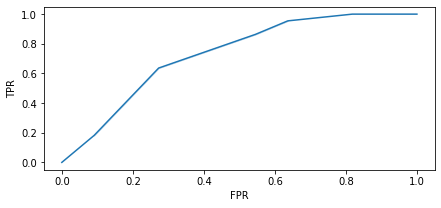

In [37]:
rcParams['figure.figsize'] = 7, 3
sns.lineplot(x = "FPR", y = "TPR", data = AUC_Curve_df, ci = False)
plt.show()

# Multinomial Naive Bayes

In [38]:
from sklearn.naive_bayes import MultinomialNB

NB = MultinomialNB()
NB.fit(X_train, y_train)
y_pred = NB.predict(X_test)
print("y_pred = {}\n".format(list(y_pred)))
print("y_test = {}\n".format(list(y_test)))

print("AUC Score: {:.2f}\n".format(roc_auc_score(y_pred, y_test)))
print(classification_report(y_pred, y_test))

y_pred = [0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0]

y_test = [0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0]

AUC Score: 0.64

              precision    recall  f1-score   support

           0       0.64      0.64      0.64        11
           1       0.64      0.64      0.64        11

    accuracy                           0.64        22
   macro avg       0.64      0.64      0.64        22
weighted avg       0.64      0.64      0.64        22

